## Understanding Flair Dataset
This notebook tries provides details on the structure of the flair dataset and makes suggestions how to process the data.

In [147]:
import os, sys, time
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def parse_flair_dates(df, date_column):
    """Parse date strings separately for those with/without time component, interpret those without as midnight (00AM)
        Args:
            df (pandas DataFrame): data frame holding data
            date_column (string): column name that holds date time strings to be used for parsing

        Returns:
            df (pandas DataFrame): with new DateTime column holding datetime objects
        """
    #
    b_only_date = (df[date_column].str.len() <= 10)
    print(sum(b_only_date))
    df.loc[b_only_date, 'DateTime'] = pd.to_datetime(df.loc[b_only_date, date_column], format='%m/%d/%Y')
    df.loc[~b_only_date, 'DateTime'] = pd.to_datetime(df.loc[~b_only_date, date_column], format='%m/%d/%Y %I:%M:%S %p')
    return df

## load the data

In [122]:
current_dir = os.getcwd(); 
print(current_dir)
data_path = os.path.join(current_dir, '..', 'data/raw')
print(data_path)
insulin_path = os.path.join(data_path,'FLAIRPublicDataSet','Data Tables', 'FLAIRDevicePump.txt')
print(insulin_path)

df_insulin = pd.read_csv(insulin_path, sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur','BolusType', 'BolusDeliv', 'ExtendBolusDuration'])
df_insulin = parse_flair_dates(df_insulin,'DataDtTm')
display(df_insulin.head())

/Users/jan/git/nudgebg/egvinsulin/notebooks
/Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw
/Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/FLAIRPublicDataSet/Data Tables/FLAIRDevicePump.txt
35150


,RecID,PtID,DataDtTm,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,DateTime
0,1,26,5/15/2019 11:59:59 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 23:59:59
1,2,26,5/15/2019 11:58:26 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:58:26
2,3,26,5/15/2019 11:53:26 PM,NaN,NaN,NaN,NaN,Normal,0.050,NaN,2019-05-15 23:53:26
3,4,26,5/15/2019 11:48:28 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:48:28
4,5,26,5/15/2019 11:43:28 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:43:28


In [133]:
print("overall data counts:")
print(df_insulin.count(),"\n")
print("bolus types:")
print(df_insulin.BolusType.value_counts(),"\n")
print("temp basal types:")
print(df_insulin.TempBasalType.value_counts(),"\n")

overall data counts:
RecID                  5100621
PtID                   5100621
DataDtTm               5100621
BasalRt                  60668
TempBasalAmt              1446
TempBasalType             1446
TempBasalDur              1446
BolusType              3946622
BolusDeliv             3555501
ExtendBolusDuration        445
DateTime               5100621
dtype: int64 

bolus types:
Normal                3945345
Dual (square part)        697
Dual (normal part)        534
Square                     46
Name: BolusType, dtype: int64 

**basal types**:
Percent    1437
Rate          9
Name: TempBasalType, dtype: int64 



* We also have (697 or 534) dual wave and 46 sqaure (extended) boluses
* The dual wave boluses square/normal part) don't match
* We have 1446 temp basal values
* only 9 of these are set by insulin rate, the others are in percent

### Are temp basal amounts always units?

In [137]:
display(df_insulin.loc[df_insulin.TempBasalType =="Percent",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType']].head())
display(df_insulin.loc[df_insulin.TempBasalType =="Rate",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType']].head())

,DateTime,BasalRt,TempBasalAmt,TempBasalType
16499,2019-03-11 12:46:39,NaN,100.0,Percent
29868,2019-03-10 23:59:21,NaN,50.0,Percent
29884,2019-03-10 15:43:56,NaN,0.0,Percent
29886,2019-03-10 15:42:57,NaN,0.0,Percent
41568,2019-06-05 11:08:18,NaN,0.0,Percent


,DateTime,BasalRt,TempBasalAmt,TempBasalType
58519,2019-06-24 11:47:55,NaN,0.1,Rate
498999,2019-05-17 08:04:58,NaN,1.6,Rate
500045,2019-05-06 11:44:36,NaN,1.3,Rate
500214,2019-05-04 21:16:36,NaN,1.0,Rate
500876,2019-04-24 20:01:41,NaN,1.1,Rate


# What is temp Percent 100 mean?
According to Lane, 100% refers to the normal basal rate. Medtronic allows setting temp basal percentages from 0 (shut off) to 200% (twice the basal rate). These values are confirmed by the histogram of the data:

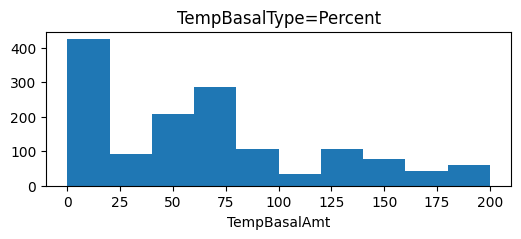

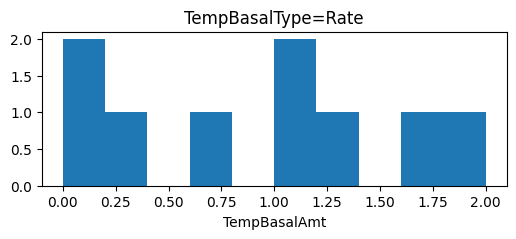

In [163]:
plt.figure(figsize=(6,2)); plt.xlabel("TempBasalAmt"); plt.title("TempBasalType=Percent")
plt.hist(df_insulin.loc[df_insulin.TempBasalType =="Percent",'TempBasalAmt']);

plt.figure(figsize=(6,2)); plt.xlabel("TempBasalAmt"); plt.title("TempBasalType=Rate")
plt.hist(df_insulin.loc[df_insulin.TempBasalType =="Rate",'TempBasalAmt']);

The Max basal rate is the maximum amount of basal insulin that the pump can deliver per hour. Set the Max basal rate as indicated by a healthcare professional. It is not possible to set a basal rate, a temp basal rate, or a preset temp basal rate that would exceed the Max basal rate limit. After the basal patterns or preset temp basal rates are set, the Max basal rate cannot be lower than any of the existing basal rates. The Max basal rate can be set from 0 to 35 units per hour.

Temp basal rates
The temp basal feature helps set and start a temporary basal rate that can be used immediately to manage BG for short-term activities or conditions.
Preset temp basal rates can be set for recurring short term situations. For more information on Preset temp basal rates, see Preset temp basal rates, page 239. The duration of the temp basal rate can range from 30 minutes to 24 hours. After the temp basal rate delivery is completed or canceled, the programmed basal pattern resumes. The temp basal rates and preset temp basal rates can be defined using either a percentage of the current basal pattern or by setting a specific rate, as described in the following table:
Temp basal rate type
Percent
Description
Percent delivers a percentage of the basal rates pro‐ grammed in the active basal pattern for the duration of the temp basal rate. The temp basal amount is rounded down to the next 0.025 units if the basal rate is set at less than 1 unit per hour, or to the next 0.05 units if the basal rate is set at more than 1 unit per hour.
Temp basal rates can be set to deliver from 0% to 200% of the scheduled basal rate. The percentage used is based on the largest basal rate scheduled during the temp basal rate duration and is limited by the Max basal rate.
Rate delivers a fixed basal insulin rate in units per hour for the duration of the temp basal rate. The amount set is limited by the Max basal rate.

<div>
<img src="Bolus Types Medtronic.png" width="500"/>
</div>

Bolus types
**Normal bolus**: provides a single immediate dose of insulin.
**Square Wave bolus**: delivers a single bolus evenly over an extended period of time from 30 minutes up to 8 hours.
**Dual Wave bolus**: delivers a combination of an immediate normal bo‐ lus followed by a Square Wave bolus.

[1] MiniMed-780G-system-user-guide-with-Guardian-4-sensor.pdf

In [ ]:
display(df_insulin.loc[~df_insulin.TempBasalType.isna(),['DateTime','BasalRt', 'TempBasalAmt','TempBasalType']])

In [142]:
import random
def first_days_random_patient(df,days=3):
    random_id = random.choice(df_insulin.PtID.unique())
    temp = df_insulin.loc[df_insulin.PtID==random_id]
    return temp.loc[temp.DateTime<temp.DateTime.min()+timedelta(hours=72)]

Text(0.5, 1.0, 'raw')

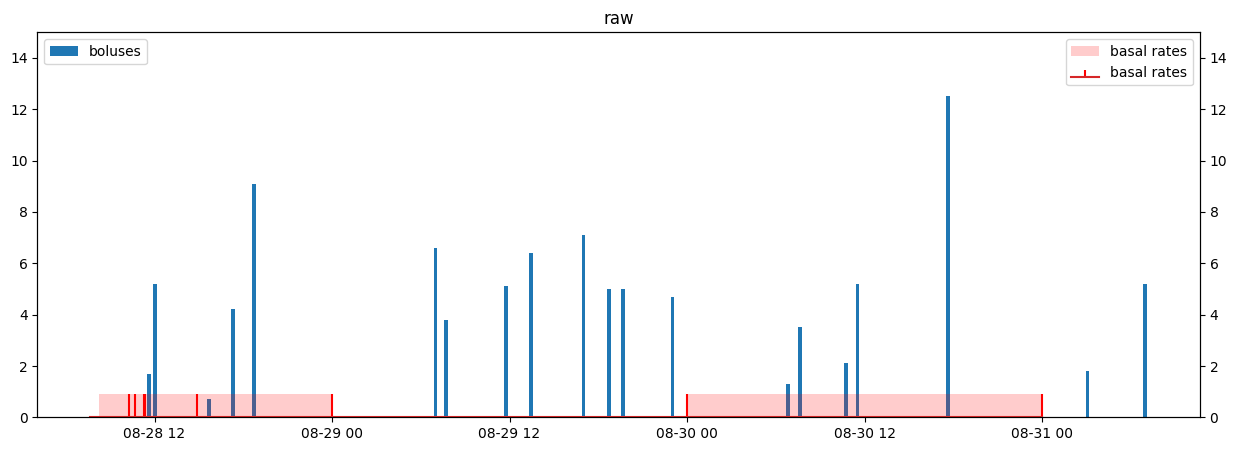

In [155]:
sub_frame =first_days_random_patient(df_insulin, 5)
boluses = sub_frame.dropna(subset=['BolusDeliv'],axis=0)
basalRates = sub_frame.dropna(subset=['BasalRt'],axis=0)

f = plt.figure(figsize=(15,5))
ax = f.gca();

sub_frame.sort_values("DateTime",inplace=True)


ax.bar(boluses.DateTime, boluses.BolusDeliv, width=timedelta(minutes=15), label='boluses')
ax.legend(loc='upper left')

twinax=plt.twinx()
twinax.stem(basalRates.DateTime, basalRates.BasalRt, label='basal rates',markerfmt='None',linefmt='r-')
twinax.stairs(basalRates.BasalRt.iloc[:-1],basalRates.DateTime, label='basal rates',color='red',fill=True,alpha=0.2,)

plt.legend(loc="upper right")

ax.set_ylim([0,15]);
twinax.set_ylim([0,15])

plt.title("raw")